In [1]:
import torch
import numpy as np
import data
import tqdm
import models
from torchvision.transforms import v2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
EPOCHS = 50
BATCH_SIZE = 32
LR = 1e-6
OUT_CLASSES = 3

In [ ]:
def transform(image):
    """
    Data augmentation by random rotation, and random scaling between 0.8 to 1.2

    :param image: Image before transform
    :return: Image after transform 
    """
    image = v2.RandomAffine(degrees=(-180,180),scale=(0.8,1.2))(image)
    return image

In [3]:
train_dataset = data.LensingDataset('index.csv','../dataset/train/',
                                    transform=transform)
test_dataset = data.LensingDataset('index.csv','../dataset/val/',
                                   transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               shuffle=True,
                                               batch_size=BATCH_SIZE,
                                               num_workers=15)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              shuffle=True,
                                              batch_size=BATCH_SIZE,
                                              num_workers=15)

In [5]:
model = models.resnet_classifier(in_channels=1,out_classes=3).to(device)
model.load_state_dict(torch.load('resnet_18.pt'))

loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(params=model.parameters(),lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,'min',patience=3,factor=0.1)
history = {'val_loss':[], 'acc':[], 'loss':[]}
best_val_loss = np.inf
best_weights = None
for epoch in range(EPOCHS):
    losses = []
    accs = []
    model.train()
    for i,(x,y) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x, y) = (x.float().to(device), y.to(device))
        x = model(x)
        loss = loss_fn(x,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        label_indices = torch.argmax(y, 1)
        prediction_indices = torch.argmax(x, 1)
        acc = float(torch.sum(label_indices == prediction_indices))/float(len(label_indices))
        losses.append(float(loss))
        accs.append(float(acc))
    print("Training at epoch %d/%d: %.4f with acc=%.5f at LR=%.6f"%(epoch+1,EPOCHS,np.mean(losses),np.mean(accs),opt.param_groups[0]['lr']))
    history['loss'].append(np.mean(losses))
    train_loss = np.mean(losses)
    model.eval()
    losses = []
    accs = []
    for i,(x,y) in enumerate(tqdm.tqdm(test_dataloader, desc=f"Validation epoch {epoch}")):
        (x, y) = (x.float().to(device), y.to(device))
        x = model(x)
        val_loss = loss_fn(x,y)
        label_indices = torch.argmax(y, 1)
        prediction_indices = torch.argmax(x, 1)
        acc = float(torch.sum(label_indices == prediction_indices))/float(len(label_indices))
        losses.append(float(val_loss))
        accs.append(float(acc))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = model.state_dict()
    history['val_loss'].append(np.mean(losses))
    history['acc'].append(np.mean(accs))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} with acc={np.mean(accs)} at LR={opt.param_groups[0]['lr']}")
    scheduler.step(np.mean(losses))
    if opt.param_groups[0]['lr'] < 1e-9:
        print("Breaking as learning rate is too small")
        break



Training epoch 1: 100%|██████████| 938/938 [01:55<00:00,  8.11it/s]


Training at epoch 1/1000: 0.2883 with acc=0.88999 at LR=0.000001


Validation epoch 0: 100%|██████████| 235/235 [00:11<00:00, 21.10it/s]


Validation at epoch 1/1000: 0.403625534649225 with acc=0.8672429078014183 at LR=1e-06


Training epoch 2: 100%|██████████| 938/938 [01:53<00:00,  8.28it/s]


Training at epoch 2/1000: 0.2812 with acc=0.89319 at LR=0.000001


Validation epoch 1: 100%|██████████| 235/235 [00:11<00:00, 21.13it/s]


Validation at epoch 2/1000: 0.43638966205589313 with acc=0.8555851063829787 at LR=1e-06


Training epoch 3: 100%|██████████| 938/938 [01:53<00:00,  8.26it/s]


Training at epoch 3/1000: 0.2723 with acc=0.89656 at LR=0.000001


Validation epoch 2: 100%|██████████| 235/235 [00:11<00:00, 21.11it/s]


Validation at epoch 3/1000: 0.3740479783749485 with acc=0.8632978723404255 at LR=1e-06


Training epoch 4: 100%|██████████| 938/938 [01:53<00:00,  8.25it/s]


Training at epoch 4/1000: 0.2740 with acc=0.89412 at LR=0.000001


Validation epoch 3: 100%|██████████| 235/235 [00:11<00:00, 21.22it/s]


Validation at epoch 4/1000: 0.3531386795275389 with acc=0.8772606382978724 at LR=1e-06


Training epoch 5: 100%|██████████| 938/938 [01:53<00:00,  8.26it/s]


Training at epoch 5/1000: 0.2690 with acc=0.89772 at LR=0.000001


Validation epoch 4: 100%|██████████| 235/235 [00:11<00:00, 21.18it/s]


Validation at epoch 5/1000: 0.35352635768816826 with acc=0.8739361702127659 at LR=1e-06


Training epoch 6: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 6/1000: 0.2639 with acc=0.90102 at LR=0.000001


Validation epoch 5: 100%|██████████| 235/235 [00:11<00:00, 21.00it/s]


Validation at epoch 6/1000: 0.33147562380800855 with acc=0.8713209219858157 at LR=1e-06


Training epoch 7: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 7/1000: 0.2596 with acc=0.90219 at LR=0.000001


Validation epoch 6: 100%|██████████| 235/235 [00:11<00:00, 21.02it/s]


Validation at epoch 7/1000: 0.3967435913200074 with acc=0.8663120567375886 at LR=1e-06


Training epoch 8: 100%|██████████| 938/938 [01:53<00:00,  8.23it/s]


Training at epoch 8/1000: 0.2582 with acc=0.90355 at LR=0.000001


Validation epoch 7: 100%|██████████| 235/235 [00:11<00:00, 21.00it/s]


Validation at epoch 8/1000: 0.48336843910052424 with acc=0.8582890070921987 at LR=1e-06


Training epoch 9: 100%|██████████| 938/938 [01:53<00:00,  8.25it/s]


Training at epoch 9/1000: 0.2584 with acc=0.90252 at LR=0.000001


Validation epoch 8: 100%|██████████| 235/235 [00:11<00:00, 21.05it/s]


Validation at epoch 9/1000: 0.34207583339290415 with acc=0.8762854609929077 at LR=1e-06


Training epoch 10: 100%|██████████| 938/938 [01:53<00:00,  8.23it/s]


Training at epoch 10/1000: 0.2607 with acc=0.90199 at LR=0.000001


Validation epoch 9: 100%|██████████| 235/235 [00:11<00:00, 21.05it/s]


Validation at epoch 10/1000: 0.42554355932677046 with acc=0.8740248226950353 at LR=1e-06


Training epoch 11: 100%|██████████| 938/938 [01:54<00:00,  8.23it/s]


Training at epoch 11/1000: 0.2586 with acc=0.90355 at LR=0.000001


Validation epoch 10: 100%|██████████| 235/235 [00:11<00:00, 21.02it/s]


Validation at epoch 11/1000: 0.36907431212987035 with acc=0.8706117021276596 at LR=1e-06


Training epoch 12: 100%|██████████| 938/938 [01:54<00:00,  8.23it/s]


Training at epoch 12/1000: 0.2570 with acc=0.90309 at LR=0.000001


Validation epoch 11: 100%|██████████| 235/235 [00:11<00:00, 21.01it/s]


Validation at epoch 12/1000: 0.3748250137776771 with acc=0.8743794326241136 at LR=1e-06


Training epoch 13: 100%|██████████| 938/938 [01:54<00:00,  8.19it/s]


Training at epoch 13/1000: 0.2539 with acc=0.90462 at LR=0.000001


Validation epoch 12: 100%|██████████| 235/235 [00:11<00:00, 21.06it/s]


Validation at epoch 13/1000: 0.30303173516183457 with acc=0.8853280141843971 at LR=1e-06


Training epoch 14: 100%|██████████| 938/938 [01:53<00:00,  8.25it/s]


Training at epoch 14/1000: 0.2572 with acc=0.90385 at LR=0.000001


Validation epoch 13: 100%|██████████| 235/235 [00:11<00:00, 21.05it/s]


Validation at epoch 14/1000: 0.5213978584935056 with acc=0.863031914893617 at LR=1e-06


Training epoch 15: 100%|██████████| 938/938 [01:54<00:00,  8.22it/s]


Training at epoch 15/1000: 0.2565 with acc=0.90392 at LR=0.000001


Validation epoch 14: 100%|██████████| 235/235 [00:11<00:00, 21.06it/s]


Validation at epoch 15/1000: 0.4148460934691607 with acc=0.8687056737588652 at LR=1e-06


Training epoch 16: 100%|██████████| 938/938 [01:54<00:00,  8.23it/s]


Training at epoch 16/1000: 0.2551 with acc=0.90215 at LR=0.000001


Validation epoch 15: 100%|██████████| 235/235 [00:11<00:00, 20.99it/s]


Validation at epoch 16/1000: 0.49180123396217823 with acc=0.8660017730496454 at LR=1e-06


Training epoch 17: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 17/1000: 0.2491 with acc=0.90665 at LR=0.000001


Validation epoch 16: 100%|██████████| 235/235 [00:11<00:00, 21.19it/s]


Validation at epoch 17/1000: 0.43793603385144725 with acc=0.8649379432624115 at LR=1e-06


Training epoch 18: 100%|██████████| 938/938 [01:53<00:00,  8.25it/s]


Training at epoch 18/1000: 0.2551 with acc=0.90199 at LR=0.000001


Validation epoch 17: 100%|██████████| 235/235 [00:11<00:00, 21.04it/s]


Validation at epoch 18/1000: 0.411549196776716 with acc=0.8736258865248226 at LR=1e-06


Training epoch 19: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 19/1000: 0.2512 with acc=0.90518 at LR=0.000001


Validation epoch 18: 100%|██████████| 235/235 [00:11<00:00, 20.96it/s]


Validation at epoch 19/1000: 0.4061678671297875 with acc=0.875 at LR=1e-06


Training epoch 20: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 20/1000: 0.2514 with acc=0.90342 at LR=0.000001


Validation epoch 19: 100%|██████████| 235/235 [00:11<00:00, 21.01it/s]


Validation at epoch 20/1000: 0.310305535928049 with acc=0.8879432624113476 at LR=1e-06


Training epoch 21: 100%|██████████| 938/938 [01:53<00:00,  8.25it/s]


Training at epoch 21/1000: 0.2516 with acc=0.90452 at LR=0.000001


Validation epoch 20: 100%|██████████| 235/235 [00:11<00:00, 21.03it/s]


Validation at epoch 21/1000: 0.3772456003947461 with acc=0.8742021276595745 at LR=1e-06


Training epoch 22: 100%|██████████| 938/938 [01:53<00:00,  8.25it/s]


Training at epoch 22/1000: 0.2469 with acc=0.90578 at LR=0.000000


Validation epoch 21: 100%|██████████| 235/235 [00:11<00:00, 21.07it/s]


Validation at epoch 22/1000: 0.3995013920788435 with acc=0.882136524822695 at LR=1e-07


Training epoch 23: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 23/1000: 0.2479 with acc=0.90478 at LR=0.000000


Validation epoch 22: 100%|██████████| 235/235 [00:11<00:00, 21.07it/s]


Validation at epoch 23/1000: 0.40736943285198923 with acc=0.8715425531914893 at LR=1e-07


Training epoch 24: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 24/1000: 0.2494 with acc=0.90608 at LR=0.000000


Validation epoch 23: 100%|██████████| 235/235 [00:11<00:00, 21.05it/s]


Validation at epoch 24/1000: 0.5777275268543274 with acc=0.8573581560283688 at LR=1e-07


Training epoch 25: 100%|██████████| 938/938 [01:53<00:00,  8.26it/s]


Training at epoch 25/1000: 0.2436 with acc=0.90922 at LR=0.000000


Validation epoch 24: 100%|██████████| 235/235 [00:11<00:00, 21.00it/s]


Validation at epoch 25/1000: 0.6260790570857043 with acc=0.8508421985815604 at LR=1e-07


Training epoch 26: 100%|██████████| 938/938 [01:53<00:00,  8.23it/s]


Training at epoch 26/1000: 0.2472 with acc=0.90572 at LR=0.000000


Validation epoch 25: 100%|██████████| 235/235 [00:11<00:00, 21.05it/s]


Validation at epoch 26/1000: 0.3152112605605037 with acc=0.8900709219858157 at LR=1e-07


Training epoch 27: 100%|██████████| 938/938 [01:53<00:00,  8.23it/s]


Training at epoch 27/1000: 0.2477 with acc=0.90725 at LR=0.000000


Validation epoch 26: 100%|██████████| 235/235 [00:11<00:00, 20.92it/s]


Validation at epoch 27/1000: 0.5335415471384817 with acc=0.8594414893617022 at LR=1e-07


Training epoch 28: 100%|██████████| 938/938 [01:53<00:00,  8.25it/s]


Training at epoch 28/1000: 0.2459 with acc=0.90708 at LR=0.000000


Validation epoch 27: 100%|██████████| 235/235 [00:11<00:00, 21.03it/s]


Validation at epoch 28/1000: 0.3035500073052467 with acc=0.8863475177304966 at LR=1e-07


Training epoch 29: 100%|██████████| 938/938 [01:54<00:00,  8.22it/s]


Training at epoch 29/1000: 0.2485 with acc=0.90525 at LR=0.000000


Validation epoch 28: 100%|██████████| 235/235 [00:11<00:00, 21.04it/s]


Validation at epoch 29/1000: 0.6546341971514072 with acc=0.8492907801418439 at LR=1e-07


Training epoch 30: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 30/1000: 0.2482 with acc=0.90702 at LR=0.000000


Validation epoch 29: 100%|██████████| 235/235 [00:11<00:00, 21.04it/s]


Validation at epoch 30/1000: 0.36751324016046016 with acc=0.8714982269503545 at LR=1e-08


Training epoch 31: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 31/1000: 0.2486 with acc=0.90505 at LR=0.000000


Validation epoch 30: 100%|██████████| 235/235 [00:11<00:00, 21.05it/s]


Validation at epoch 31/1000: 0.29834057328073266 with acc=0.8917553191489361 at LR=1e-08


Training epoch 32: 100%|██████████| 938/938 [01:53<00:00,  8.23it/s]


Training at epoch 32/1000: 0.2490 with acc=0.90565 at LR=0.000000


Validation epoch 31: 100%|██████████| 235/235 [00:11<00:00, 21.04it/s]


Validation at epoch 32/1000: 0.3951107783916783 with acc=0.8773936170212766 at LR=1e-08


Training epoch 33: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 33/1000: 0.2528 with acc=0.90502 at LR=0.000000


Validation epoch 32: 100%|██████████| 235/235 [00:11<00:00, 21.01it/s]


Validation at epoch 33/1000: 0.34577820678340626 with acc=0.884485815602837 at LR=1e-08


Training epoch 34: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 34/1000: 0.2490 with acc=0.90588 at LR=0.000000


Validation epoch 33: 100%|██████████| 235/235 [00:11<00:00, 21.06it/s]


Validation at epoch 34/1000: 0.3283149396485471 with acc=0.8789007092198582 at LR=1e-08


Training epoch 35: 100%|██████████| 938/938 [01:53<00:00,  8.27it/s]


Training at epoch 35/1000: 0.2512 with acc=0.90525 at LR=0.000000


Validation epoch 34: 100%|██████████| 235/235 [00:11<00:00, 21.11it/s]


Validation at epoch 35/1000: 0.3320708575717946 with acc=0.8786790780141843 at LR=1e-08


Training epoch 36: 100%|██████████| 938/938 [01:53<00:00,  8.26it/s]


Training at epoch 36/1000: 0.2496 with acc=0.90612 at LR=0.000000


Validation epoch 35: 100%|██████████| 235/235 [00:11<00:00, 20.80it/s]


Validation at epoch 36/1000: 0.4862167833491843 with acc=0.8624113475177306 at LR=1e-08


Training epoch 37: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 37/1000: 0.2498 with acc=0.90682 at LR=0.000000


Validation epoch 36: 100%|██████████| 235/235 [00:11<00:00, 21.12it/s]


Validation at epoch 37/1000: 0.4778519348934927 with acc=0.8681294326241136 at LR=1e-08


Training epoch 38: 100%|██████████| 938/938 [01:53<00:00,  8.26it/s]


Training at epoch 38/1000: 0.2540 with acc=0.90332 at LR=0.000000


Validation epoch 37: 100%|██████████| 235/235 [00:11<00:00, 21.09it/s]


Validation at epoch 38/1000: 0.6752233259221341 with acc=0.8482712765957446 at LR=1e-08


Training epoch 39: 100%|██████████| 938/938 [01:53<00:00,  8.23it/s]


Training at epoch 39/1000: 0.2477 with acc=0.90638 at LR=0.000000


Validation epoch 38: 100%|██████████| 235/235 [00:11<00:00, 21.12it/s]


Validation at epoch 39/1000: 0.40027017015567484 with acc=0.877482269503546 at LR=1e-08


Training epoch 40: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 40/1000: 0.2467 with acc=0.90762 at LR=0.000000


Validation epoch 39: 100%|██████████| 235/235 [00:11<00:00, 21.06it/s]


Validation at epoch 40/1000: 0.2978836828406821 with acc=0.8877216312056737 at LR=1e-08


Training epoch 41: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 41/1000: 0.2498 with acc=0.90548 at LR=0.000000


Validation epoch 40: 100%|██████████| 235/235 [00:11<00:00, 21.04it/s]


Validation at epoch 41/1000: 0.4134796390785499 with acc=0.8675531914893617 at LR=1e-08


Training epoch 42: 100%|██████████| 938/938 [01:53<00:00,  8.23it/s]


Training at epoch 42/1000: 0.2494 with acc=0.90555 at LR=0.000000


Validation epoch 41: 100%|██████████| 235/235 [00:11<00:00, 21.07it/s]


Validation at epoch 42/1000: 0.33271682380520284 with acc=0.8802304964539008 at LR=1e-08


Training epoch 43: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 43/1000: 0.2492 with acc=0.90652 at LR=0.000000


Validation epoch 42: 100%|██████████| 235/235 [00:11<00:00, 21.07it/s]


Validation at epoch 43/1000: 0.5436687913346798 with acc=0.85979609929078 at LR=1e-08


Training epoch 44: 100%|██████████| 938/938 [01:53<00:00,  8.27it/s]


Training at epoch 44/1000: 0.2510 with acc=0.90592 at LR=0.000000


Validation epoch 43: 100%|██████████| 235/235 [00:11<00:00, 21.05it/s]


Validation at epoch 44/1000: 0.32826140072751553 with acc=0.8794326241134752 at LR=1e-08


Training epoch 45: 100%|██████████| 938/938 [01:53<00:00,  8.27it/s]


Training at epoch 45/1000: 0.2487 with acc=0.90715 at LR=0.000000


Validation epoch 44: 100%|██████████| 235/235 [00:11<00:00, 21.04it/s]


Validation at epoch 45/1000: 0.35014413054636184 with acc=0.8786347517730497 at LR=1e-08


Training epoch 46: 100%|██████████| 938/938 [01:53<00:00,  8.27it/s]


Training at epoch 46/1000: 0.2433 with acc=0.90755 at LR=0.000000


Validation epoch 45: 100%|██████████| 235/235 [00:11<00:00, 21.06it/s]


Validation at epoch 46/1000: 0.3610070566706201 with acc=0.8831117021276595 at LR=1e-08


Training epoch 47: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 47/1000: 0.2444 with acc=0.90845 at LR=0.000000


Validation epoch 46: 100%|██████████| 235/235 [00:11<00:00, 20.96it/s]


Validation at epoch 47/1000: 0.528861050323603 with acc=0.8644060283687944 at LR=1e-08


Training epoch 48: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 48/1000: 0.2464 with acc=0.90825 at LR=0.000000


Validation epoch 47: 100%|██████████| 235/235 [00:11<00:00, 21.06it/s]


Validation at epoch 48/1000: 0.46412944425135216 with acc=0.8702570921985816 at LR=1e-08


Training epoch 49: 100%|██████████| 938/938 [01:54<00:00,  8.22it/s]


Training at epoch 49/1000: 0.2437 with acc=0.90862 at LR=0.000000


Validation epoch 48: 100%|██████████| 235/235 [00:11<00:00, 21.15it/s]


Validation at epoch 49/1000: 0.447752584513039 with acc=0.874468085106383 at LR=1e-08


Training epoch 50: 100%|██████████| 938/938 [01:53<00:00,  8.25it/s]


Training at epoch 50/1000: 0.2514 with acc=0.90558 at LR=0.000000


Validation epoch 49: 100%|██████████| 235/235 [00:11<00:00, 21.12it/s]


Validation at epoch 50/1000: 0.3323312905874658 with acc=0.879654255319149 at LR=1e-08


Training epoch 51: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Training at epoch 51/1000: 0.2504 with acc=0.90605 at LR=0.000000


Validation epoch 50: 100%|██████████| 235/235 [00:11<00:00, 21.15it/s]


Validation at epoch 51/1000: 0.43362827031536305 with acc=0.8714095744680851 at LR=1e-08


Training epoch 52:  73%|███████▎  | 684/938 [01:23<00:30,  8.20it/s]


In [ ]:
model.load_state_dict(best_weights)
torch.save(model.state_dict(), 'resnet_18_fine.pt')

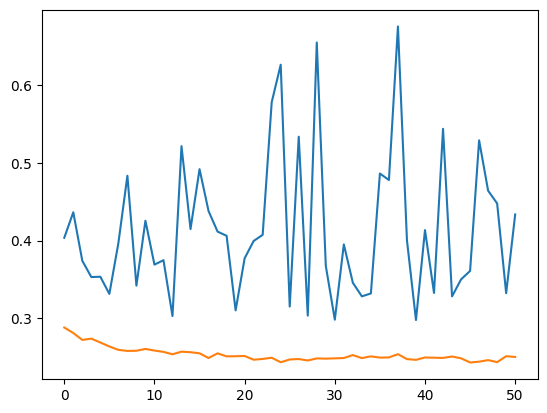

In [6]:
import matplotlib.pyplot as plt
plt.plot(history['val_loss'])
plt.plot(history['loss'])